## 생존분석에 사용되는 scikit-survival
* [An Introduction to Survival Analysis with scikit-survival](https://nbviewer.jupyter.org/github/sebp/scikit-survival/blob/master/examples/00-introduction.ipynb) 페이지의 소스코드를 이용함
* scikit-survival이 설치되지 않았다면, 설치 후 이용<br>
`!conda install -c sebp scikit-survival`

In [1]:
#폐암환자 데이터 불러오기. 데이터 설명은 http://lib.stat.cmu.edu/datasets/veteran 참고
from sksurv.datasets import load_veterans_lung_cancer

In [2]:
data_x, data_y = load_veterans_lung_cancer()
data_y

#status와 survival in days를 골라 array로 보기. True = 사망

array([( True,  72.), ( True, 411.), ( True, 228.), ( True, 126.),
       ( True, 118.), ( True,  10.), ( True,  82.), ( True, 110.),
       ( True, 314.), (False, 100.), ( True,  42.), ( True,   8.),
       ( True, 144.), (False,  25.), ( True,  11.), ( True,  30.),
       ( True, 384.), ( True,   4.), ( True,  54.), ( True,  13.),
       (False, 123.), (False,  97.), ( True, 153.), ( True,  59.),
       ( True, 117.), ( True,  16.), ( True, 151.), ( True,  22.),
       ( True,  56.), ( True,  21.), ( True,  18.), ( True, 139.),
       ( True,  20.), ( True,  31.), ( True,  52.), ( True, 287.),
       ( True,  18.), ( True,  51.), ( True, 122.), ( True,  27.),
       ( True,  54.), ( True,   7.), ( True,  63.), ( True, 392.),
       ( True,  10.), ( True,   8.), ( True,  92.), ( True,  35.),
       ( True, 117.), ( True, 132.), ( True,  12.), ( True, 162.),
       ( True,   3.), ( True,  95.), ( True, 177.), ( True, 162.),
       ( True, 216.), ( True, 553.), ( True, 278.), ( True,  1

---
### Kaplan-Meier estimator 이용해보기
* 아래 데이터를 분석한다고 가정했을 때, 4번 환자가 t=30 에서 살아있는지 알 수 없으므로 이를 알아보기 위해 K-M 추정을 이용하게 됨

In [3]:
import pandas as pd
pd.DataFrame.from_records(data_y[[11, 5, 32, 13, 23]], index=range(1, 6))

,Status,Survival_in_days
1,True,8.0
2,True,10.0
3,True,20.0
4,False,25.0
5,True,59.0


Text(0.5, 0, 'time $t$')

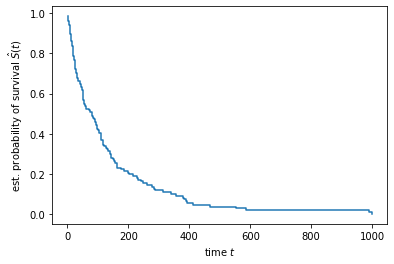

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob = kaplan_meier_estimator(data_y["Status"], data_y["Survival_in_days"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

#$로 묶으면 이텔릭체, \hat{}로 묶으면 햇 기호
#첫 200일 사이에 많은 환자가 사망한 것을 확인할 수 있다

---
### 분류군별 생존 곡선 그리기
* 아래와 같은 데이터에서 Treatment 또는 Celltype에 따른 생존 시간 차이를 알아볼 수 있는 그래프 그리기

In [5]:
data_x.head()

,Age_in_years,Celltype,Karnofsky_score,Months_from_Diagnosis,Prior_therapy,Treatment
0,69.0,squamous,60.0,7.0,no,standard
1,64.0,squamous,70.0,5.0,yes,standard
2,38.0,squamous,60.0,3.0,no,standard
3,63.0,squamous,60.0,9.0,yes,standard
4,65.0,squamous,70.0,11.0,yes,standard


In [6]:
data_x["Treatment"].value_counts()

standard    69
test        68
Name: Treatment, dtype: int64

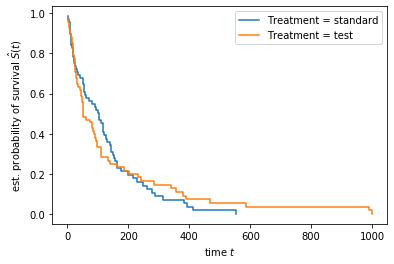

In [7]:
#standard와 test 분류군별 생존곡선 그리기

#standard끼리 한 번, test끼리 한 번 K-M plot을 그린다. 분류는 masking을 통해서.
for treatment_type in ("standard", "test"):
    mask_treat = data_x["Treatment"] == treatment_type
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(data_y["Status"][mask_treat], data_y["Survival_in_days"][mask_treat])
    
    plt.step(time_treatment, survival_prob_treatment, where="post", label="Treatment = %s" % treatment_type)
    
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

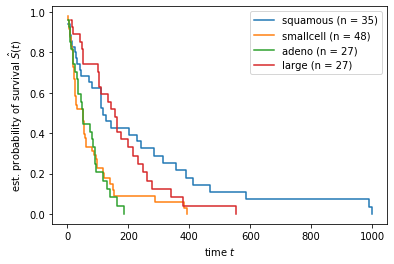

In [10]:
#cell type에 따른 생존곡선 그리기. unique() 함수를 이용해 일일히 입력하지 않아도 되게 할 수 있다

for value in data_x["Celltype"].unique():
    mask = data_x["Celltype"] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(data_y["Status"][mask],
                                                           data_y["Survival_in_days"][mask])
    plt.step(time_cell, survival_prob_cell, where="post",
             label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

---
### 다변량 생존 모델
* Cox's proportional hazard's model 이용할 것

In [8]:
from sksurv.preprocessing import OneHotEncoder

#one hot encoder를 이용해 data_x를 숫자 값으로 변형해 이용. 각 data마다 0 or 1의 값으로 표시되게끔 재설정됨
data_x_numeric = OneHotEncoder().fit_transform(data_x)
data_x_numeric.head()

,Age_in_years,Celltype=large,Celltype=smallcell,Celltype=squamous,Karnofsky_score,Months_from_Diagnosis,Prior_therapy=yes,Treatment=test
0,69.0,0.0,0.0,1.0,60.0,7.0,0.0,0.0
1,64.0,0.0,0.0,1.0,70.0,5.0,1.0,0.0
2,38.0,0.0,0.0,1.0,60.0,3.0,0.0,0.0
3,63.0,0.0,0.0,1.0,60.0,9.0,1.0,0.0
4,65.0,0.0,0.0,1.0,70.0,11.0,1.0,0.0


In [9]:
from sksurv.linear_model import CoxPHSurvivalAnalysis

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x_numeric, data_y)

CoxPHSurvivalAnalysis(alpha=0, n_iter=100, tol=1e-09, verbose=0)

In [11]:
#분석 결과: 각 변수마다 log hazard ratio를 표현함
pd.Series(estimator.coef_, index=data_x_numeric.columns)

Age_in_years            -0.008549
Celltype=large          -0.788672
Celltype=smallcell      -0.331813
Celltype=squamous       -1.188299
Karnofsky_score         -0.032622
Months_from_Diagnosis   -0.000092
Prior_therapy=yes        0.072327
Treatment=test           0.289936
dtype: float64

In [12]:
#분류군별로 환자를 분류하기 위한 마스크 만들기
#모든 group은 65세, Karnofsky_score=60, 진단 후 1개월이며
#Celltype=squamous 중 치료 O/X group
#Celltype=smallcell 중 치료 O/X group 으로 구분한다.

x_new = pd.DataFrame.from_dict({
    1: [65,0,0,1,60,1,0,1],
    2: [65,0,0,1,60,1,0,0],
    3: [65,0,1,0,60,1,0,0],
    4: [65,0,1,0,60,1,0,1]},
    columns=data_x_numeric.columns, orient='index')
x_new

,Age_in_years,Celltype=large,Celltype=smallcell,Celltype=squamous,Karnofsky_score,Months_from_Diagnosis,Prior_therapy=yes,Treatment=test
1,65,0,0,1,60,1,0,1
2,65,0,0,1,60,1,0,0
3,65,0,1,0,60,1,0,0
4,65,0,1,0,60,1,0,1


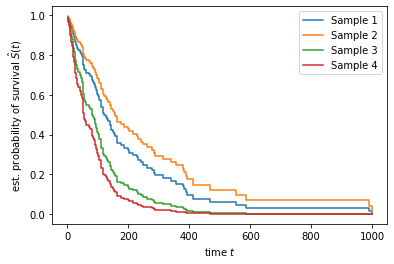

In [13]:
#네 그룹의 생존확률 시각화
pred_surv = estimator.predict_survival_function(x_new) #마스크 적용
for i, c in enumerate(pred_surv):
    plt.step(c.x, c.y, where='post', label='Sample %d' % (i+1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

---
### 생존 모델 평가
* Harrell's concordance index (또는 c-index) 라는 평가법을 사용

|value=0.5|value=1.0|value=0.0|
|---------|---------|---------|
|random model|perfect model|perfectly wrong model|

In [16]:
from sksurv.metrics import concordance_index_censored

estimator.score(data_x_numeric, data_y)
#해당 모델은 random하지 않지만, perfect model과도 거리가 있음을 알 수 있다

0.7362562471603816

---
### 가장 생존률 예측에 주요한 항목 알아보기

In [17]:
import numpy as np

def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(data_x_numeric.values, data_y)
pd.Series(scores, index=data_x_numeric.columns).sort_values(ascending=False)

#Karnofsky_score가 가장 예측에 주요하며, 하위 두 항목은 거의 예측에 영향이 없음을 알 수 있다

Karnofsky_score          0.709280
Celltype=smallcell       0.572581
Celltype=large           0.561620
Celltype=squamous        0.550545
Treatment=test           0.525386
Age_in_years             0.515107
Months_from_Diagnosis    0.509030
Prior_therapy=yes        0.494434
dtype: float64

In [18]:
#관련 없는 항목 cut-off. sklearn 내장 기능을 이용함

from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline

pipe = Pipeline([('encode', OneHotEncoder()),
                 ('select', SelectKBest(fit_and_score_features, k=3)),
                 ('model', CoxPHSurvivalAnalysis())])

In [19]:
#test score 작성 및 dataframe화

from sklearn.model_selection import GridSearchCV

param_grid = {'select__k': np.arange(1, data_x_numeric.shape[1] + 1)}
gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=3, iid=True)
gcv.fit(data_x, data_y)

pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_select__k,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
2,0.263257,0.017558,0.009483,0.000089,3,{'select__k': 3},0.650628,0.718220,0.754649,0.707491,0.043067,1,0.765569,0.695647,0.714082,0.725099,0.029590
4,0.263439,0.017611,0.009475,0.000084,5,{'select__k': 5},0.644874,0.738347,0.728822,0.703834,0.042098,2,0.783946,0.698207,0.718498,0.733551,0.036585
3,0.263315,0.017215,0.009470,0.000096,4,{'select__k': 4},0.650628,0.719809,0.725723,0.698523,0.034138,3,0.768121,0.691037,0.707327,0.722162,0.033172
1,0.266249,0.019678,0.009502,0.000085,2,{'select__k': 2},0.630753,0.717161,0.747934,0.698256,0.049604,4,0.758550,0.683611,0.705638,0.715933,0.031448
0,0.281108,0.035958,0.009982,0.000598,1,{'select__k': 1},0.630753,0.715042,0.737087,0.693982,0.045843,5,0.744640,0.676697,0.695246,0.705527,0.028675
5,0.266732,0.019194,0.010138,0.000876,6,{'select__k': 6},0.657427,0.669492,0.724690,0.683572,0.029179,6,0.783946,0.698848,0.716160,0.732985,0.036722
6,0.265963,0.018887,0.009508,0.000078,7,{'select__k': 7},0.654812,0.659958,0.714876,0.676269,0.027083,7,0.788412,0.695519,0.712133,0.732021,0.040447
7,0.266008,0.018681,0.009548,0.000060,8,{'select__k': 8},0.656904,0.653602,0.716942,0.675516,0.029004,8,0.786371,0.695006,0.713692,0.731690,0.039411


In [20]:
#앞서 작성한 pipe에 fit 시켜서 가장 주요한 3개의 feature를 확인함

pipe.set_params(**gcv.best_params_)
pipe.fit(data_x, data_y)

encoder, transformer, final_estimator = [s[1] for s in pipe.steps]
pd.Series(final_estimator.coef_, index=encoder.encoded_columns_[transformer.get_support()])

Celltype=large       -0.067277
Celltype=smallcell    0.271007
Karnofsky_score      -0.031285
dtype: float64